In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\Users\diego.renteria\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


            #guests
time               
2012-01-01      238
2012-02-01      129
2012-03-01      110
2012-04-01      230
2012-05-01      158
DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
        

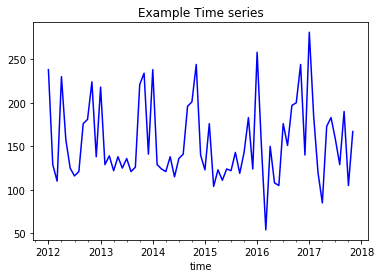

time
2012-01-01    238
2012-02-01    129
2012-03-01    110
2012-04-01    230
2012-05-01    158
2012-06-01    125
2012-07-01    116
2012-08-01    121
2012-09-01    176
2012-10-01    181
Name: #guests, dtype: int64

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
print(data.head())
print(data.index)
ts = data['#guests']
ts.plot(c='b', title='Example Time series')
plt.show()
ts.head(10)

In [3]:
TS = np.array(ts)
num_periods = 6
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 6, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 6, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

11
(11, 6, 1)
[[[238]
  [129]
  [110]
  [230]
  [158]
  [125]]

 [[116]
  [121]
  [176]
  [181]
  [224]
  [138]]]
[[[129]
  [110]
  [230]
  [158]
  [125]
  [116]]]
(11, 6, 1)


In [4]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 6, 1)
    testY = TS[-(num_periods):].reshape(-1, 6, 1)
    return testX,testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 6, 1)
[[[173]
  [183]
  [158]
  [129]
  [190]
  [105]]]


In [5]:
tf.reset_default_graph()

num_periods = 6
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#BasicRNNCell
#BasicLSTMCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [6]:
epochs = 5000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 1865227.2
100 	MSE: 139188.0
200 	MSE: 51724.65
300 	MSE: 55623.41
400 	MSE: 30094.78
500 	MSE: 26975.572
600 	MSE: 21722.705
700 	MSE: 17449.094
800 	MSE: 12580.334
900 	MSE: 12383.239
1000 	MSE: 29600.832
1100 	MSE: 8652.11
1200 	MSE: 6346.2837
1300 	MSE: 146907.11
1400 	MSE: 22656.084
1500 	MSE: 9171.404
1600 	MSE: 7938.2197
1700 	MSE: 9546.609
1800 	MSE: 7229.3433
1900 	MSE: 6055.933
2000 	MSE: 5393.6294
2100 	MSE: 4696.692
2200 	MSE: 4402.64
2300 	MSE: 4184.6836
2400 	MSE: 4537.3057
2500 	MSE: 3983.9465
2600 	MSE: 3860.795
2700 	MSE: 3794.0842
2800 	MSE: 3752.6055
2900 	MSE: 3718.605
3000 	MSE: 3694.912
3100 	MSE: 5751.83
3200 	MSE: 3858.8225
3300 	MSE: 3719.1863
3400 	MSE: 3681.2195
3500 	MSE: 3661.506
3600 	MSE: 3646.6846
3700 	MSE: 3634.2808
3800 	MSE: 3623.8054
3900 	MSE: 3614.8665
4000 	MSE: 3607.4841
4100 	MSE: 3600.979
4200 	MSE: 3594.8484
4300 	MSE: 3592.246
4400 	MSE: 3585.2854
4500 	MSE: 3583.0168
4600 	MSE: 3577.6104
4700 	MSE: 3594.8054
4800 	MSE: 3569.8594
490

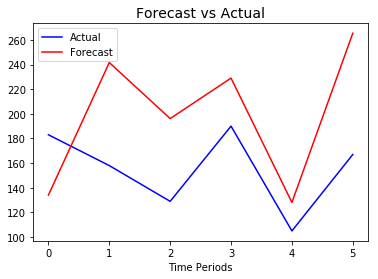

TEST
[[[183]
  [158]
  [129]
  [190]
  [105]
  [167]]]
PRED
[[[134.04057]
  [241.59407]
  [196.13005]
  [228.97139]
  [128.09541]
  [265.3712 ]]]


In [7]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
print('TEST')
print(Y_test)
print('PRED')
print(y_pred)